# AVORIM for a Poisson simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.autograd as autograd

from IPython.display import clear_output
from tqdm import tqdm

## Constants

### Simulator parameters

In [2]:
lambda_poisson = 7
nb_samples = 20000

### Network parameters

In [3]:
batch_size = 64
lambda_gp = 1
gamma_entropy = 100

In [4]:
critic_params = {"lr": 1e-3,
                 "nb_steps": 1,
                 "nb_hiddens": 10
                }

In [5]:
proposal_params = {"lr": 1e-3,
                   "beta1": 0.5,
                   "beta2": 0.9
                  }

In [6]:
gen_params = {"nb_steps": 1}

## Generation of the data

### Build the simulator

In [7]:
def simulator(theta):
    # lambda = exp(theta) (for positivity)
    return np.random.poisson(np.exp(theta))

### Generate the data

In [8]:
X_obs = simulator([np.log(lambda_poisson) for i in range(nb_samples)])
X_obs = X_obs[:,np.newaxis]
X_obs = torch.Tensor(X_obs)

## Definition of the optimizer

### RMSprop

In [24]:
class RmsPropOptimizer:
    def __init__(self, size_input, lr=0.01, gamma=1., eps=10**-8):
        self.size_input = size_input
        self.lr = lr
        self.gamma = gamma
        self.eps = eps

        self.reset()

    def reset(self):
        self.avg_sq_grad = torch.ones(self.size_input)

    def step(self, grad_approx, num_iters=1):
        v = 0
        for i in range(num_iters):
            self.avg_sq_grad = self.avg_sq_grad * self.gamma + grad_approx**2 * (1 - self.gamma)
            v = v + self.lr * grad_approx / torch.sqrt(self.avg_sq_grad + self.eps)
        v /= num_iters
        print("step: ", v)
        return v

In [25]:
rms = RmsPropOptimizer(1, lr=0.1)
x = torch.tensor([1.], requires_grad=True)
y = x**2

In [58]:
x.grad = torch.tensor([0.])
y.backward(retain_graph=True)
x.data.sub_(rms.step(x.grad))

step:  tensor(1.00000e-03 *
       [ 3.6029])


tensor(1.00000e-02 *
       [ 1.4412])

## Definition of the proposal distribution $q$

In [27]:
class Proposal(nn.Module):
    def __init__(self, lr=0.01):
        super(Proposal, self).__init__()
        
        self.psi = Parameter(torch.tensor([0., -1.]), requires_grad=True) # mean and log(std)

        self.optimizer = RmsPropOptimizer(self.psi.shape[0], lr=lr)
        
    def forward(self, size):
        return self.psi[0] +  torch.exp(self.psi[1]) * torch.normal(torch.zeros((size, 1)), torch.ones((size, 1)))
    
    def backprop(self, grad_approx):
        step = self.optimizer.step(grad_approx)
        self.psi[0].data.sub_(step[0])
        
    def pdf(self, theta):
        return 1. / torch.sqrt(2 * np.pi * torch.exp(self.psi[1])**2) * torch.exp(-(torch.exp(theta) - self.psi[0])**2 / (2 * torch.exp(self.psi[1])))

In [28]:
p = Proposal()

In [29]:
p.zero_grad()
l = torch.log(p.pdf(torch.tensor(0.)))
l.backward()

In [30]:
p.psi.grad

tensor([ 2.7183,  0.3591])

In [31]:
p.pdf(torch.tensor(0.1))

tensor(0.2062)

## Building the networks

### Losses

In [32]:
def wgan_critic_loss(C_gen, C_real):
    return torch.mean(C_gen) - torch.mean(C_real)

def wgan_generator_loss(C_gen):
    return -torch.mean(C_gen)

In [33]:
def ogan_critic_loss(C_gen, C_real, eps=1e-8):
    return torch.mean(- torch.log(C_real+eps) - torch.log(1 - C_gen+eps))

def ogan_generator_loss(C_gen, eps=1e-8):
    return -torch.mean(torch.log(C_gen+eps))

In [34]:
def gradient_penalty(critic, X_real):
    X_real.requires_grad_(True)
    C_real = critic.forward(X_real)
    out_grad = torch.ones(X_real.shape[0], 1) # used to define the size of the grad (grad_C(C) = [1,1,...])
    gradients = autograd.grad(outputs=C_real, inputs=X_real,
                              grad_outputs=out_grad, create_graph=True, retain_graph=True,
                              only_inputs=True)[0]
    return ((gradients.norm(2, dim=1))**2).mean()

### Critic

In [35]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(1,critic_params["nb_hiddens"])
        self.fc2 = nn.Linear(critic_params["nb_hiddens"],critic_params["nb_hiddens"])
        self.fc3 = nn.Linear(critic_params["nb_hiddens"],1)
        
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=critic_params["lr"])
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))
        
        return out
    
    def loss(self, X_gen, X_real):
        C_gen = self.forward(X_gen)
        C_real = self.forward(X_real)
#         print("C_gen", C_gen)
#         print("C_real", C_real)
        
        return ogan_critic_loss(C_gen, C_real) #+ lambda_gp * gradient_penalty(self, X_real)

### Generator

In [60]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
    def forward(self, theta):
        theta_np = theta.detach().numpy()
        x_np = simulator(theta_np)
        return torch.FloatTensor(x_np)
    
    def loss(self, C_gen):
        return ogan_generator_loss(C_gen)
    
    def grad_approx(self, proposal, theta, C_gen, eps=1e-8):
#         log_q_batch = torch.log(proposal.pdf(theta))
        
#         proposal.zero_grad()
#         log_q_batch = torch.log(proposal.pdf(theta.detach()))
#         log_q_batch.backward(-C_gen)
#         grad_batch = proposal.psi.grad

        grad_u = 0
        for i in range(len(theta)):
            proposal.zero_grad()
            log_q = torch.log(proposal.pdf(theta[i]) + eps)
            log_q.backward()
            grad_u += - C_gen[i] * proposal.psi.grad
        print("pdf", proposal.pdf(theta[i].detach()))

        grad_u /= theta.shape[0]
            
        return grad_u
    
    def entropy(self, proposal, theta, eps=1e-8):
        grad_h = 0
        for i in range(len(theta)):
            proposal.zero_grad()
            q = proposal.pdf(theta[i].detach())
            H = q * torch.log(q + eps)
            H.backward()
            grad_h += proposal.psi.grad

        grad_h /= theta.shape[0]
            
        return grad_h
    
    def backprop(self, proposal, theta, C_gen):
        grad_u = self.grad_approx(proposal, theta.detach(), C_gen)
        grad_h = self.entropy(proposal, theta)
        print("grad_u", grad_u)
        print("grad_h", gamma_entropy * grad_h)
        proposal.backprop(grad_u + 0 * grad_h)

## Main loop

In [61]:
i = 0
C_loss_list = []
G_loss_list = []

proposal = Proposal(lr=0.01)
critic = Critic()
generator = Generator()

In [62]:
from time import sleep
# print(proposal.psi)
critic_params["nb_steps"] = 5
gen_params["nb_steps"] = 2

nb_iter = 100
for i in range(i,i+nb_iter):
    critic.optimizer.zero_grad()
    
    for i_critic in range(critic_params["nb_steps"]):
        X_real_sample = X_obs[np.random.choice(len(X_obs), batch_size)]
        theta_sample = proposal.forward(batch_size)
        X_gen_sample = torch.FloatTensor(simulator(theta_sample.detach().numpy()))
        
        C_loss = critic.loss(X_gen_sample, X_real_sample)
        C_loss.backward()
        critic.optimizer.step()
    
    # validation
    X_real_sample = X_obs[np.random.choice(len(X_obs), batch_size)]
    theta_sample = proposal.forward(batch_size)
    X_gen_sample = torch.FloatTensor(simulator(theta_sample.detach().numpy()))
    C_loss = critic.loss(X_gen_sample, X_real_sample)   
    C_loss_list.append(C_loss)
        
    for i_gen in range(gen_params["nb_steps"]):
        theta_sample = proposal.forward(batch_size)
        C_gen = critic(generator.forward(theta_sample.detach()))
        G_loss_list.append(generator.loss(C_gen))
        sleep(0.1)
        clear_output(wait=True)
        generator.backprop(proposal, theta_sample, C_gen)
        print("Psi: ", proposal.psi)

print("Critic Loss: ", C_loss)

pdf tensor(1.00000e-03 *
       [ 1.2718])
grad_u tensor([-0.4120, -0.5302])
grad_h tensor([-0.8154, -0.5042])
step:  tensor(1.00000e-03 *
       [-4.1201, -5.3018])
Psi:  Parameter containing:
tensor([ 2.1869, -1.0000])


KeyboardInterrupt: 

Text(0,0.5,'Generator loss')

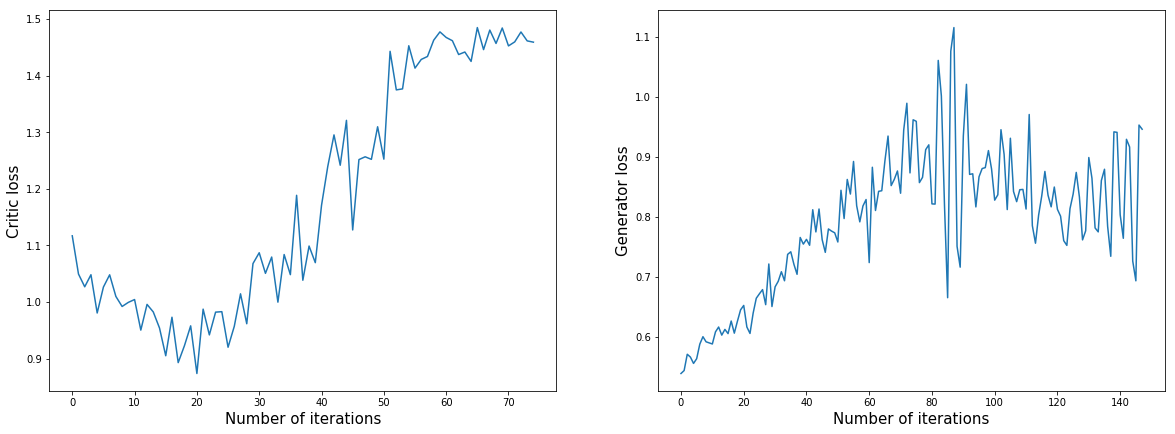

In [59]:
plt.rcParams["figure.figsize"] = (20,7)

plt.subplot(1,2,1)

plt.plot(C_loss_list)
plt.xlabel("Number of iterations", size=15)
plt.ylabel("Critic loss", size=15)

plt.subplot(1,2,2)

plt.plot(G_loss_list)
plt.xlabel("Number of iterations", size=15)
plt.ylabel("Generator loss", size=15)

## Visualization

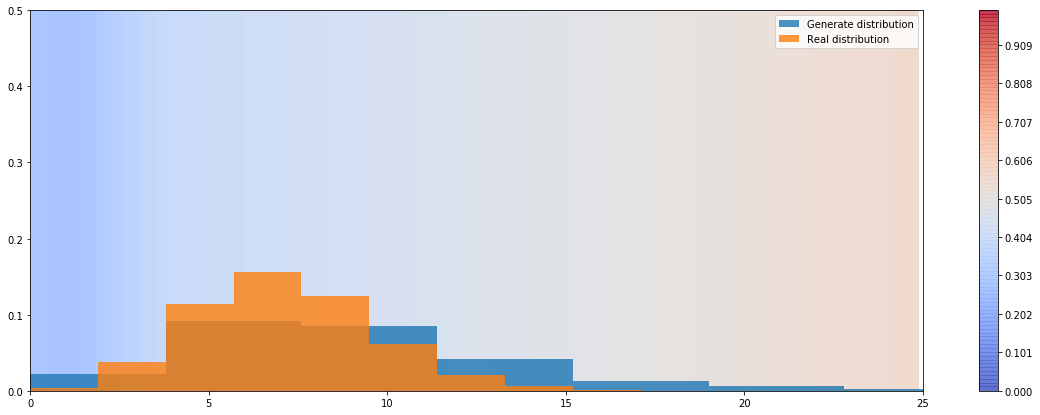

In [459]:
theta_sample = proposal.forward(20000)
X_gen_sample = torch.FloatTensor(simulator(theta_sample.detach().numpy()))

hist1 = plt.hist(X_gen_sample[:,0], label="Generate distribution", density=True, alpha=0.8)
hist2 = plt.hist(X_obs[:,0], label="Real distribution", density=True, alpha=0.8)

cm = plt.cm.coolwarm

x_min, x_max = 0, 25
y_min, y_max = 0, 0.6
h = .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
levels = np.linspace(0,1,100)
eps = 1
Z = critic.forward(torch.FloatTensor(xx.reshape(xx.shape[0]*xx.shape[1], 1))).detach()
Z = Z.reshape(xx.shape[0], xx.shape[1])
plt.contourf(xx, yy, Z, levels, cmap=cm, alpha=0.8)

plt.xlim(0,25)
plt.ylim(0, 0.5)
plt.colorbar()
plt.legend()

In [118]:
simulator(max(theta_sample.detach()))

array([4505])

In [119]:
max(theta_sample.detach())

tensor([ 8.3894])

In [ ]:
xx.reshape(xx.shape[0]*xx.shape[1], 1)

In [ ]:
np.log(xx.reshape(xx.shape[0]*xx.shape[1], 1) + eps)

In [ ]:
np.log(xx.reshape(xx.shape[0]*xx.shape[1], 1) + eps)

In [104]:
np.exp(6)

403.4287934927351